In [106]:
import pandas as pd
from glob import glob
from datetime import *

import pylab as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [6]:
with open('pipeline_data/steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()

## Load ground truth

In [56]:
csv_fname = glob('pipeline_data/data_????-??-??_glm.csv')[0]
df = pd.read_csv(csv_fname, dtype={'fips': str})

In [93]:
case_gnd = df[['fips', f'case{len(steps) - 1}']].copy()
case_gnd['state'] = case_gnd['fips'].apply(lambda x: x[:2])
case_gnd = case_gnd.groupby(by='state').sum()
case_total = case_gnd.sum()
case_gnd.loc['US', :] = case_total
case_gnd = case_gnd.rename(columns={f'case{len(steps)-1}': 'gnd'})
case_gnd.index.name='location'
case_gnd.head()

,gnd
location,
01,10197.0
02,2730.0
04,11438.0
05,8994.0
06,37219.0


In [94]:
death_gnd = df[['fips', f'death{len(steps) - 1}']].copy()
death_gnd['state'] = death_gnd['fips'].apply(lambda x: x[:2])
death_gnd = death_gnd.groupby(by='state').sum()
death_total = death_gnd.sum()
death_gnd.loc['US', :] = death_total
death_gnd = death_gnd.rename(columns={f'death{len(steps)-1}': 'gnd'})
death_gnd.index.name='location'
death_gnd.head()

,gnd
location,
01,117.0
02,2.0
04,169.0
05,143.0
06,302.0


## Load prediction and join with ground truth

In [68]:
cur_dt = datetime.strptime(steps[-1], '%Y-%m-%d')
fc_dt = (cur_dt + timedelta(days=1)).date()
prd_csv = glob(f'submission/{fc_dt}*csv')[0]
prd = pd.read_csv(prd_csv)

In [95]:
case_prd_state_1 = prd[ 
    (prd.location.str.len() == 2) & 
    (prd.target == '1 wk ahead inc case')].set_index('location')
case_prd_state_2 = prd[ 
    (prd.location.str.len() == 2) & 
    (prd.target == '2 wk ahead inc case')].set_index('location')

case_prds = [case_prd_state_1, case_prd_state_2]

case_prd = pd.DataFrame()
for i in range(2):
    tmp = case_prds[i]
    w = i + 1
    case_prd[f'{w}-wk'] = tmp[tmp['type'] == 'point']['value']
    case_prd[f'{w}-wk_10'] = tmp[ (tmp['type'] == 'quantile') & (tmp['quantile'] == .1) ]['value']
    case_prd[f'{w}-wk_90'] = tmp[ (tmp['type'] == 'quantile') & (tmp['quantile'] == .9) ]['value']

case = case_gnd.join(case_prd)

In [96]:
death_prd_state_1 = prd[ 
    (prd.location.str.len() == 2) & 
    (prd.target == '1 wk ahead inc death')].set_index('location')
death_prd_state_2 = prd[ 
    (prd.location.str.len() == 2) & 
    (prd.target == '2 wk ahead inc death')].set_index('location')

death_prds = [death_prd_state_1, death_prd_state_2]

death_prd = pd.DataFrame()
for i in range(2):
    tmp = death_prds[i]
    w = i + 1
    death_prd[f'{w}-wk'] = tmp[tmp['type'] == 'point']['value']
    death_prd[f'{w}-wk_10'] = tmp[ (tmp['type'] == 'quantile') & (tmp['quantile'] == .1) ]['value']
    death_prd[f'{w}-wk_90'] = tmp[ (tmp['type'] == 'quantile') & (tmp['quantile'] == .9) ]['value']
death = death_gnd.join(death_prd)

<AxesSubplot:xlabel='location'>

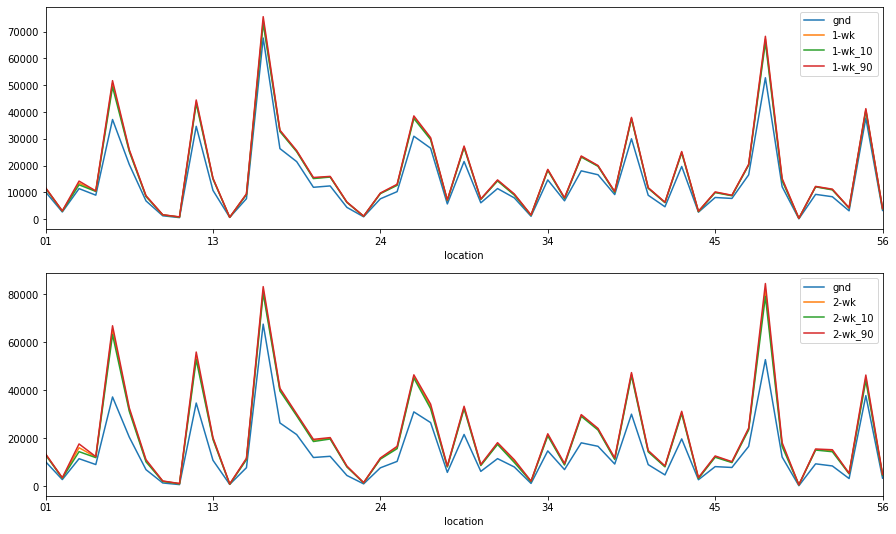

In [107]:
fig, axes = plt.subplots(2, 1, figsize=(15, 9))
case[:-1][['gnd'] + [col for col in case.columns if col.startswith('1')]].plot(ax=axes[0])
case[:-1][['gnd'] + [col for col in case.columns if col.startswith('2')]].plot(ax=axes[1])

In [108]:
case.loc['US']

gnd         719340.00
1-wk        881712.02
1-wk_10     877508.01
1-wk_90     885473.33
2-wk       1058847.86
2-wk_10    1047888.05
2-wk_90    1068313.66
Name: US, dtype: float64

<AxesSubplot:xlabel='location'>

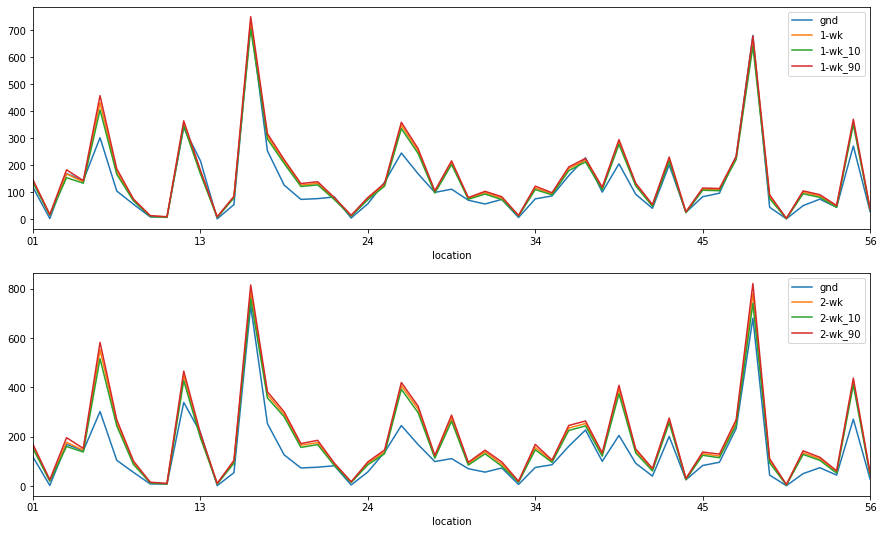

In [109]:
fig, axes = plt.subplots(2, 1, figsize=(15, 9))
death[:-1][['gnd'] + [col for col in death.columns if col.startswith('1')]].plot(ax=axes[0])
death[:-1][['gnd'] + [col for col in death.columns if col.startswith('2')]].plot(ax=axes[1])

In [105]:
death.loc['US']

gnd        6702.000000
1-wk       8012.579201
1-wk_10    7850.260807
1-wk_90    8172.150616
2-wk       9691.885329
2-wk_10    9481.807287
2-wk_90    9928.078665
Name: US, dtype: float64